# Tabula Rasa

---

---

### Overview

This notebook trains a mixed monotonic model, with sub-models to generate arbitrary quantile predictions and estimate epistemic uncertainty, using `TabulaRasaRegressor()`.

It's designed to work with Pandas DataFrame's and takes advantage of class types and feature names to cut down on code.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabularasa.TabulaRasa import TabulaRasaRegressor

---

### Load example data

If you haven't already, please generate the example dataset using the [example_data](example_data.ipynb) notebook.

In [2]:
df = pd.read_pickle('./data/simple_train.pkl')

Let's convert `x3` to a `category` data type so that we can generate embeddings for it (`TabulaRasaRegressor()` automatically handles this for all columns with `object` or `category` data types).

In [3]:
df['x3'] = df['x3'].astype('category')

---

### Initialize  and train

When initializing the model, we typically pass 3 arguments:
- `df`: A `pandas.DataFrame` containing the training data, or a sample of it.  No training happens on initialization, just categorizing features, setting up categorical feature mappings, and scalers for numeric features.  Therefore, if it is a sample of the full dataset, it should well represent your full dataset (in terms of having unique values for each categorical feature, and distributions for continuous features).
- `targets`: A `list` of column names to use as regressand(s) which are in `df`.  All other 'number', 'category', or 'object' columns in `df` are assumed to be features and will be included in the models. 
- `monotonic_constraints`: A `dict` where keys are features (column names on `df`) to take on monotonic relationships with the `targets` and values are 1 or -1 to signify the direction of that relationship: increasing or decreasing (respectively).
- `TabulaRasaRegressor()` also accepts named arguments, which are passed to the methods that define the three models behind the scenes.  Review the source code for `TabulaRasaRegressor()._define_model()` for more detail.  Here, we only specify `lr=0.005`.

In [4]:
model = TabulaRasaRegressor(df,
                            targets=['y'],
                            monotonic_constraints={'x1': 1, 'x2': 1},
                            lr=0.003)

Now, when we run `.fit()`, we'll train 3 models:
- The first generates standard predictions.
- The second can be used to estimate epistemic uncertainty.
- The third can generate predictions for arbitrary quantiles.

Note, we break pure adherence to the scikit API and simply pass the dataset which includes both the feature and target columns we'd like to train on into `.fit()`.

In [5]:
model.fit(df)

*** Training expectation model ***
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.8900        0.8704  1.5872
      2        0.8400        0.8212  1.5734
      3        0.7668        0.7038  1.5788
      4        0.6453        0.5542  1.5646
      5        0.4856        0.3954  1.5868
      6        0.3781        0.3667  1.5879
      7        0.3030        0.2822  1.5828
      8        0.2427        0.2586  1.5828
      9        0.2292        0.2442  1.5807
     10        0.2207        0.2668  1.6009
     11        0.2053        0.2442  1.5910
     12        0.1925        0.2720  1.5592
     13        0.1818        0.2702  1.5771
     14        0.1806        0.2565  1.5648
     15        0.1796        0.2480  1.5920
     16        0.1782        0.2621  1.5771
     17        0.1784        0.2613  1.5749
     18        0.1778        0.2819  1.5655
Stopping since valid_loss has not improved in the last 10 epochs.

*** Training epist

    112        0.0096        0.0095  0.0461
    113        0.0096        0.0094  0.0503
    114        0.0096        0.0094  0.0447
    115        0.0095        0.0094  0.0467
    116        0.0095        0.0094  0.0439
    117        0.0095        0.0094  0.0445
    118        0.0095        0.0094  0.0460
    119        0.0095        0.0094  0.0437
    120        0.0095        0.0094  0.0457
    121        0.0095        0.0094  0.0455
    122        0.0095        0.0094  0.0400
    123        0.0095        0.0093  0.0437
    124        0.0094        0.0093  0.0408
    125        0.0094        0.0093  0.0434
    126        0.0094        0.0093  0.0460
    127        0.0094        0.0093  0.0476
    128        0.0094        0.0093  0.0471
    129        0.0094        0.0093  0.0454
    130        0.0094        0.0093  0.0485
    131        0.0094        0.0093  0.0413
    132        0.0094        0.0093  0.0466
    133        0.0094        0.0092  0.0460
    134        0.0093        0.0

      8        0.1155        0.1483  1.5411
      9        0.1116        0.1450  1.5456
     10        0.1176        0.1433  1.5244
     11        0.1161        0.1564  1.5414
     12        0.1177        0.1418  1.5388
     13        0.1177        0.1624  1.5329
     14        0.1129        0.1535  1.5346
Stopping since valid_loss has not improved in the last 10 epochs.


We'll create a partial dependence plot to visualize how the monotonic network constrained our relationship between `x1` and `y`.

In [6]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

Note, the `.predict()` method for `TabulaRasaRegressor()` accepts a data frame as well.  This data frame must include all training features, but does not need to include target column(s).

In [7]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict(dfc)
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

We can see below that, unlike with the simple MLP network, we have a monotonically increasing relationship between `x1` and `y`.

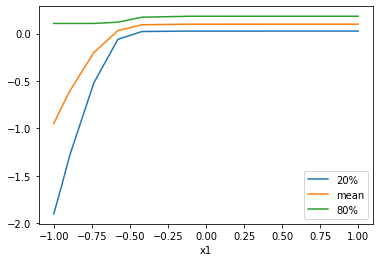

In [8]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

---

### Epistemic uncertainty

`TabulaRasaRegressor()` automatically trains and Orthornormal certificates model, and includes a method `.estimate_uncertainty()`, which accepts a data frame that must include all training features, but does not need to contain target column(s).

In [9]:
uncertainties = []
for q in np.linspace(-1.5, 1.5, 101):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.estimate_uncertainty(dfc)
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

And we can see from the plot below that uncertainties rise above 1 when projecting outside of the bounds we trained.  There is a bump in the middle, but it does not exceed 1 or align perfectly with the gap in our training data from 0 to 0.5.  Instead we see higher uncertainty when the function shows  high degree of curvature.

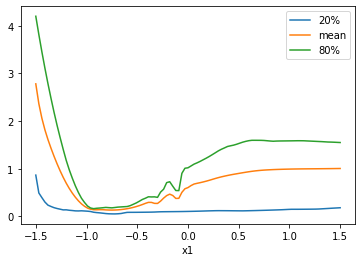

In [10]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

---

### Aleatoric uncertainty

`TabulaRasaRegressor()` also automatically trains a simultaneous quantile regression model.  Let's see how to use that.

Since each distinct value of `x3` contains all values of `x1`, let's examine prediction intervals by `x1` for a single value of `x3`.

In [11]:
df_slice = df[df['x3'] == 0].copy()

The `.predict_quantile()` takes in an extra argument `q` to specify which quantile should be predicted (defaults to 0.5, the 50th percentile).

In [12]:
p05 = model.predict_quantile(df_slice, q=0.05)
p = model.predict(df_slice)
p50 = model.predict_quantile(df_slice, q=0.5)
p95 = model.predict_quantile(df_slice, q=0.95)

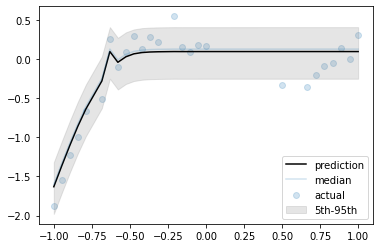

In [13]:
plt.scatter(df_slice['x1'], df_slice['y'], alpha=0.2, label='actual')
plt.plot(df_slice['x1'], p.flatten(), color='black', label='prediction')
plt.plot(df_slice['x1'], p50.flatten(), alpha=0.2, label='median')
plt.fill_between(df_slice['x1'], p05.flatten(), p95.flatten(), color='gray', alpha=0.2, label='5th-95th')
plt.legend()
plt.show()

We can see the 5th and 95th percentile prediction bounds capture the variation of most points around the median and base prediction model estimate, and can be used to approximate the aleatoric uncertainty in our model.